In [1]:
%%capture
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers datasets accelerate peft trl bitsandbytes
!pip install unsloth

In [2]:
import pandas as pd
from sklearn.utils import shuffle
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_path = "/content/drive/MyDrive/"

In [4]:
# Load the Text dataset (RAFT)
text_file = os.path.join(drive_path, "pharma_raft_tab.jsonl")
df_text = pd.read_json(text_file, lines=True)

In [5]:
# Load the Image dataset (OCR)
img_file = os.path.join(drive_path, "pipeline_ocr.jsonl")
df_img = pd.read_json(img_file, lines=True)

In [6]:
# Concatenate (Merge both datasets)
df_master = pd.concat([df_text, df_img], ignore_index=True)

# Random suffle
df_master = shuffle(df_master, random_state=42).reset_index(drop=True)

In [7]:
# Save the final Master Dataset in JSONL format
master_filename = "master_dataset.jsonl"
df_master.to_json(master_filename, orient="records", lines=True, force_ascii=False)

print(f"✅ Success! Master dataset created with {len(df_master)} total examples.")
print(f"   - Text Examples (RAFT): {len(df_text)}")
print(f"   - Image Examples (OCR): {len(df_img)}")

✅ Success! Master dataset created with 3217 total examples.
   - Text Examples (RAFT): 244
   - Image Examples (OCR): 2973


In [8]:
display(df_master.sample(5))

,image,instruction,context,answer
2474,NaN,A patient is prescribed Imrotab 12mg tablet fo...,medicine name: imotrax 7.5mg tablet\nchemical ...,The patient is likely to experience orthostati...
973,/content/images_processed/padded_b6_aug0.jpg,¿Qué medicamento se muestra en la imagen?,,En la imagen se observa un envase de BANOPHEN.
1131,/content/images_processed/padded_m23.jpg,¿Qué medicamento se muestra en la imagen?,,En la imagen se observa un envase de Mega-CV 625.
67,/content/images_processed/padded_j92.png,¿Qué medicamento se muestra en la imagen?,,En la imagen se observa un envase de JALAZOLAM...
2088,/content/images_processed/padded_h (73)_aug4.jpg,¿Qué medicamento se muestra en la imagen?,,En la imagen se observa un envase de HFPLUS 60.


In [9]:
import shutil

# Definir la ruta del zip en Drive y el destino en Colab
zip_path = "/content/drive/MyDrive/images_processed.zip"
extract_path = "/content/images_processed"

# Crear la carpeta de destino si no existe
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Descomprimir
!unzip -q {zip_path} -d /content/
print("✅ Imágenes extraídas correctamente en /content/images_processed/")

✅ Imágenes extraídas correctamente en /content/images_processed/


In [10]:
# 1. Crear la carpeta que tus rutas esperan
target_dir = "/content/images_processed"
os.makedirs(target_dir, exist_ok=True)

# 2. Mover todos los archivos .jpg (o el formato que uses) a esa carpeta
# Suponiendo que tus imágenes están sueltas en /content/
for file in os.listdir("/content/"):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
        shutil.move(os.path.join("/content/", file), os.path.join(target_dir, file))

print(f"✅ Archivos movidos a {target_dir}")

✅ Archivos movidos a /content/images_processed


✅ ¡Éxito! La imagen se encontró y se pudo abrir correctamente.


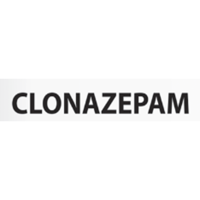

In [11]:
from PIL import Image

# Ruta ejemplo que está en tu JSONL
test_path = "/content/images_processed/padded_1.png"

if os.path.exists(test_path):
    try:
        img = Image.open(test_path)
        print("✅ ¡Éxito! La imagen se encontró y se pudo abrir correctamente.")
        display(img.resize((200, 200))) # Muestra una miniatura
    except Exception as e:
        print(f"❌ La ruta existe pero hay un error al abrir la imagen: {e}")
else:
    print("❌ Error: La ruta sigue sin ser válida. Revisa el paso anterior del enlace simbólico.")

In [12]:
from unsloth import FastVisionModel
import torch
from trl import SFTTrainer, SFTConfig

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [13]:
# Load the model and tokenizer with 4-bit quantization for memory efficiency
max_seq_length = 2048
dtype = None # Auto-detection
load_in_4bit = True

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2026.2.1: Fast Gemma3 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.35. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/4.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

In [14]:
# Apply Low-Rank Adaptation (LoRA) to reduce the number of trainable parameters
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers = False,
    finetune_language_layers = True,
    finetune_attention_modules = True,
    finetune_mlp_modules = True,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


In [15]:
from datasets import load_dataset, Image as HFImage
raw_dataset = load_dataset("json", data_files="master_dataset.jsonl", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

In [17]:
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    # Usamos .get por seguridad por si "context" no existe en algún split
    contexts     = examples.get("context", [""] * len(instructions))
    outputs      = examples["answer"]
    images_paths = examples.get("image", [None] * len(instructions))

    all_messages = []
    all_images = []

    for instruction, context, output, img_path in zip(instructions, contexts, outputs, images_paths):
        user_content = []

        # ⚠️ AQUÍ ESTÁ EL CAMBIO: una lista específica para las imágenes de ESTE ejemplo
        example_images = []

        # 1. Procesamiento de la imagen
        valid_img = False
        if img_path and isinstance(img_path, str) and str(img_path).lower() != 'nan':
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path).convert("RGB")
                    user_content.append({"type": "image"})
                    example_images.append(img)  # Agregamos la imagen a la lista de este ejemplo
                    valid_img = True
                except Exception as e:
                    print(f"⚠️ Error al abrir {img_path}: {e}")

        # 2. Procesamiento del texto
        clean_context = context if (context and str(context).lower() != 'nan') else ""

        if clean_context:
            texto_usuario = f"Context: {clean_context}\n\nQuestion: {instruction}"
        else:
            texto_usuario = f"Question: {instruction}"

        user_content.append({"type": "text", "text": texto_usuario})

        # 3. Estructura del mensaje en crudo
        messages = [
            {"role": "user", "content": user_content},
            {"role": "model", "content": [{"type": "text", "text": output}]},
        ]

        all_messages.append(messages)
        # Añadimos la lista de imágenes (que tiene 1 elemento o 0) a la lista global
        all_images.append(example_images)

    # Retornamos las listas anidadas
    return { "messages" : all_messages, "images": all_images }

In [18]:
dataset = raw_dataset.map(formatting_prompts_func, batched = True, remove_columns=raw_dataset.column_names)

Map:   0%|          | 0/3217 [00:00<?, ? examples/s]

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
FastVisionModel.for_training(model)

In [20]:
custom_collator = UnslothVisionDataCollator(
    model = model,
    processor = tokenizer,
    train_on_responses_only = True,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n"
)

In [24]:
import torch

# Guardamos la función original de PyTorch
if not hasattr(torch, "_original_layer_norm"):
    torch._original_layer_norm = torch.layer_norm

# El parche que SUBE la precisión de la entrada en lugar de BAJAR la de los pesos
def safe_layer_norm_upcast(input, normalized_shape, weight=None, bias=None, eps=1e-5, *args, **kwargs):
    original_dtype = input.dtype

    # Si la entrada viene comprimida (float16) pero los pesos exigen alta precisión (float32) para no dar NaN
    if weight is not None and weight.dtype == torch.float32 and input.dtype == torch.float16:
        # 1. Subimos la entrada temporalmente a float32
        input_fp32 = input.to(torch.float32)
        # 2. Hacemos el cálculo seguro en float32
        out = torch._original_layer_norm(input_fp32, normalized_shape, weight, bias, eps, *args, **kwargs)
        # 3. Devolvemos el resultado al formato original (float16) para que el Trainer siga fluyendo
        return out.to(original_dtype)

    # Comportamiento normal para el resto de capas
    return torch._original_layer_norm(input, normalized_shape, weight, bias, eps, *args, **kwargs)

# Aplicamos el parche
torch.layer_norm = safe_layer_norm_upcast
print("🛡️ ¡Parche Upcast activado! Adiós a los errores de dimensión y al Loss NaN.")

🛡️ ¡Parche Upcast activado! Adiós a los errores de dimensión y al Loss NaN.


In [51]:
# Configure the SFTTrainer with optimized hyperparameters
#is_bfloat16_supported = torch.cuda.is_bf16_supported()

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = custom_collator, # Usar el collator visual
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1, # Las imágenes consumen más VRAM, mantén esto bajo
        gradient_accumulation_steps = 8,
        gradient_checkpointing = True, # Sube la acumulación si bajas el batch
        warmup_ratio = 0.2,
        max_steps = 5,
        learning_rate = 2e-5,
        logging_steps = 1,
        optim = "adamw_torch",
        max_seq_length = max_seq_length,
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",
        packing = False,
        remove_unused_columns = False,
        dataset_text_field = "messages",
        dataset_kwargs = {"skip_prepare_dataset": True},
        fp16 = False,
        bf16 = False,
        max_grad_norm = 0.1,
    ),
)

Unsloth: Switching to float32 training since model cannot work with float16


In [26]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.563 GB.
5.59 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,217 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 29,802,496 of 4,329,881,968 (0.69% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,nan
2,nan


In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

In [ ]:
FastVisionModel.for_inference(model)

In [ ]:
# Cargar una imagen de test
test_image_path = "ruta_a_tu_imagen_de_prueba.jpg"
image = Image.open(test_image_path).convert("RGB")

instruction = "Identify the medication shown in the image and its main side effects based on your knowledge."

In [ ]:
messages = [
    {"role": "user", "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": instruction}
    ]}
]

In [ ]:
prompt = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=False,
)

In [ ]:
# El tokenizador ahora debe procesar texto e imagen simultáneamente
inputs = tokenizer(
    text=prompt,
    images=image, # Pasamos la imagen
    return_tensors="pt",
    padding=True,
).to("cuda")

In [ ]:
# 4. Generation
outputs = model.generate(**inputs, max_new_tokens = 512, use_cache = True)
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)

print("--- ASSISTANT´S ANSWER ---")
print(response[0].split("model\n")[-1])

--- RESPUESTA DEL ASISTENTE ---
Para explicar el mecanismo de acción de la warfarina y sus interacciones, es crucial comprender su forma de inhibir la vitamina K y su interacción con el citocromo P450, y de esta forma, cómo afecta la producción de factores de coagulación de la sangre.

Mecanismo de Acción:

La warfarina es un fármaco antiagregante plaquetario que actúa principalmente inhibiendo la vitamina K epóxido reductasa, una enzima crucial en el metabolismo de la vitamina K. Los factores de coagulación de la sangre, como la II, VII, IX y X, se derivan de la vitamina K. La vitamina K epóxido reductasa es esencial para activar estos factores, y es necesario para su carboxilación, una reacción que los hace funcionales como cofactores de coagulación. Al inhibir esta enzima, la warfarina bloquea la carboxilación de estos factores, lo que conduce a la producción de factores de coagulación inactivos. Esto inhibe la cascada de coagulación, previniendo la formación de coágulos sanguíneos.

In [ ]:
# Save the Fine-Tuned LoRA adapters locally
nombre_carpeta = "lora_pharma"
model.save_pretrained(nombre_carpeta)
tokenizer.save_pretrained(nombre_carpeta)

# 2.Zip the folder
import shutil
shutil.make_archive(nombre_carpeta, 'zip', nombre_carpeta)

# Download the zipped folder
from google.colab import files
files.download(f"{nombre_carpeta}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>